In [1]:
# Cell 1: Protobuf downgrade (No change, but ensure to run and restart kernel)
!pip install --quiet protobuf==3.20.3
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4

In [2]:
# Cell 2: Install scikit-learn if needed (No change)
!pip install --quiet scikit-learn

In [3]:
# Cell 3: Imports (CHANGE: No major change, but ensured all are imported correctly)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
# CHANGE: Added preprocess_input for ResNet-specific preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

print("✅ TensorFlow version:", tf.__version__)
print("✅ All libraries imported successfully!")

2025-12-18 12:58:00.966775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766062681.145093      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766062681.196760      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766062681.666268      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766062681.666310      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766062681.666313      55 computation_placer.cc:177] computation placer alr

✅ TensorFlow version: 2.19.0
✅ All libraries imported successfully!


In [4]:
# Cell 4: Dataset Paths (Kaggle)
train_dir = "/kaggle/input/fishmargedataset/margeDataset/train"
val_dir   = "/kaggle/input/fishmargedataset/margeDataset/valid"
test_dir  = "/kaggle/input/fishmargedataset/margeDataset/test"

In [5]:
# Cell 5: Data Generators

img_size = (224, 224)
batch_size = 32  

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    horizontal_flip=True,
    rotation_range=30,  
    zoom_range=0.3,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    brightness_range=[0.8, 1.2] 
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("✅ Found classes:", class_names)

Found 20597 images belonging to 20 classes.
Found 5885 images belonging to 20 classes.
Found 2943 images belonging to 20 classes.
✅ Found classes: ['Aair', 'Boal', 'Chapila', 'Foli', 'Ilish', 'KalBaush', 'Katla', 'Koi', 'Magur', 'Mrigel', 'Pabda', 'Pangas', 'Puti', 'Rui', 'Shol', 'SorPuti', 'Taki', 'Tarabaim', 'Telapiya', 'Tengra']


In [6]:
# Cell 6: Compute Class Weights for Imbalance (No change)
classes = np.unique(train_gen.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_gen.classes)
class_weights_dict = dict(enumerate(class_weights))
print("✅ Class weights computed:", class_weights_dict)

✅ Class weights computed: {0: np.float64(0.8008164852255054), 1: np.float64(0.8712774957698816), 2: np.float64(2.351255707762557), 3: np.float64(2.2634065934065934), 4: np.float64(1.2682881773399015), 5: np.float64(1.5100439882697947), 6: np.float64(0.7958655332302936), 7: np.float64(1.5416916167664672), 8: np.float64(1.9728927203065134), 9: np.float64(0.7897622699386503), 10: np.float64(0.7506195335276968), 11: np.float64(1.3823489932885906), 12: np.float64(0.8469161184210526), 13: np.float64(0.573413140311804), 14: np.float64(0.9033771929824561), 15: np.float64(3.1207575757575756), 16: np.float64(0.6008459743290548), 17: np.float64(1.006695992179863), 18: np.float64(0.6861092604930047), 19: np.float64(0.9219785138764548)}


In [7]:
# Cell 7: Show Image Counts (No change)
def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

train_count_before = count_images_in_dir(train_dir)
val_count_before = count_images_in_dir(val_dir)
test_count_before = count_images_in_dir(test_dir)

print("\n===============================")
print("📸 IMAGE COUNT SUMMARY")
print("===============================")
print(f"Original Training images: {train_count_before}")
print(f"Original Validation images: {val_count_before}")
print(f"Original Testing images: {test_count_before}")
print("----After Augmentation-------")
print(f"Train Generator samples: {train_gen.samples}")
print(f"Val Generator samples: {val_gen.samples}")
print(f"Test Generator samples: {test_gen.samples}")


📸 IMAGE COUNT SUMMARY
Original Training images: 20597
Original Validation images: 5885
Original Testing images: 2943
----After Augmentation-------
Train Generator samples: 20597
Val Generator samples: 5885
Test Generator samples: 2943


In [8]:
# Cell 8: Paths Setup (No change)
base_dir = "/kaggle/working/resnet50"
os.makedirs(base_dir, exist_ok=True)

model_path = os.path.join(base_dir, "resnet50_best.h5")
final_model_path = os.path.join(base_dir, "resnet50_final.h5")
log_path = os.path.join(base_dir, "resnet50_training_log.csv")

In [9]:
# Cell 9: Build or Load Model (ResNet50)

if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path)
else:
    print("🔹 Building new ResNet50 model...")
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x) 
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)


initial_lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=1000, decay_rate=0.9, staircase=True  

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),  
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy'),
    CSVLogger(log_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-7) 
]

🔹 Building new ResNet50 model...


I0000 00:00:1766062730.618259      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
# Cell 10: Train Phase 1 (Train top layers)
history1 = model.fit(
    train_gen,
    epochs=20, 
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9239 - loss: 0.2171

644/644 ━━━━━━━━━━━━━━━━━━━━ 361s 560ms/step - accuracy: 0.9239 - loss: 0.2171 - val_accuracy: 0.9728 - val_loss: 0.0844 - learning_rate: 7.2900e-04
Epoch 2/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 360s 558ms/step - accuracy: 0.9344 - loss: 0.1798 - val_accuracy: 0.9718 - val_loss: 0.0863 - learning_rate: 7.2900e-04
Epoch 3/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9391 - loss: 0.1618

644/644 ━━━━━━━━━━━━━━━━━━━━ 372s 577ms/step - accuracy: 0.9391 - loss: 0.1618 - val_accuracy: 0.9766 - val_loss: 0.0787 - learning_rate: 6.5610e-04
Epoch 4/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9438 - loss: 0.1579

644/644 ━━━━━━━━━━━━━━━━━━━━ 458s 712ms/step - accuracy: 0.9438 - loss: 0.1579 - val_accuracy: 0.9772 - val_loss: 0.0781 - learning_rate: 5.9049e-04
Epoch 5/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9432 - loss: 0.1500

644/644 ━━━━━━━━━━━━━━━━━━━━ 377s 585ms/step - accuracy: 0.9432 - loss: 0.1500 - val_accuracy: 0.9798 - val_loss: 0.0692 - learning_rate: 5.9049e-04
Epoch 6/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 371s 575ms/step - accuracy: 0.9441 - loss: 0.1522 - val_accuracy: 0.9771 - val_loss: 0.0903 - learning_rate: 5.3144e-04
Epoch 7/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9529 - loss: 0.1269

644/644 ━━━━━━━━━━━━━━━━━━━━ 364s 565ms/step - accuracy: 0.9529 - loss: 0.1269 - val_accuracy: 0.9823 - val_loss: 0.0554 - learning_rate: 4.7830e-04
Epoch 8/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9598 - loss: 0.1084

644/644 ━━━━━━━━━━━━━━━━━━━━ 370s 575ms/step - accuracy: 0.9598 - loss: 0.1084 - val_accuracy: 0.9839 - val_loss: 0.0548 - learning_rate: 4.7830e-04
Epoch 9/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9599 - loss: 0.1027

644/644 ━━━━━━━━━━━━━━━━━━━━ 361s 561ms/step - accuracy: 0.9599 - loss: 0.1027 - val_accuracy: 0.9842 - val_loss: 0.0541 - learning_rate: 4.3047e-04
Epoch 10/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 361s 560ms/step - accuracy: 0.9650 - loss: 0.0949 - val_accuracy: 0.9827 - val_loss: 0.0550 - learning_rate: 3.8742e-04
Epoch 11/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9616 - loss: 0.0995

644/644 ━━━━━━━━━━━━━━━━━━━━ 383s 594ms/step - accuracy: 0.9617 - loss: 0.0995 - val_accuracy: 0.9845 - val_loss: 0.0509 - learning_rate: 3.8742e-04
Epoch 12/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9628 - loss: 0.1016

644/644 ━━━━━━━━━━━━━━━━━━━━ 386s 599ms/step - accuracy: 0.9628 - loss: 0.1016 - val_accuracy: 0.9856 - val_loss: 0.0463 - learning_rate: 3.4868e-04
Epoch 13/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9646 - loss: 0.0972

644/644 ━━━━━━━━━━━━━━━━━━━━ 370s 574ms/step - accuracy: 0.9646 - loss: 0.0972 - val_accuracy: 0.9871 - val_loss: 0.0416 - learning_rate: 3.4868e-04
Epoch 14/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9680 - loss: 0.0830

644/644 ━━━━━━━━━━━━━━━━━━━━ 356s 553ms/step - accuracy: 0.9680 - loss: 0.0830 - val_accuracy: 0.9878 - val_loss: 0.0407 - learning_rate: 3.1381e-04
Epoch 15/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 363s 563ms/step - accuracy: 0.9716 - loss: 0.0718 - val_accuracy: 0.9864 - val_loss: 0.0460 - learning_rate: 2.8243e-04
Epoch 16/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9709 - loss: 0.0759

644/644 ━━━━━━━━━━━━━━━━━━━━ 353s 548ms/step - accuracy: 0.9709 - loss: 0.0759 - val_accuracy: 0.9888 - val_loss: 0.0389 - learning_rate: 2.8243e-04
Epoch 17/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9735 - loss: 0.0665

644/644 ━━━━━━━━━━━━━━━━━━━━ 356s 553ms/step - accuracy: 0.9735 - loss: 0.0665 - val_accuracy: 0.9900 - val_loss: 0.0391 - learning_rate: 2.5419e-04
Epoch 18/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 357s 555ms/step - accuracy: 0.9736 - loss: 0.0725 - val_accuracy: 0.9891 - val_loss: 0.0407 - learning_rate: 2.2877e-04
Epoch 19/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 374s 581ms/step - accuracy: 0.9755 - loss: 0.0617 - val_accuracy: 0.9893 - val_loss: 0.0390 - learning_rate: 2.2877e-04
Epoch 20/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9756 - loss: 0.0678

644/644 ━━━━━━━━━━━━━━━━━━━━ 358s 556ms/step - accuracy: 0.9756 - loss: 0.0678 - val_accuracy: 0.9901 - val_loss: 0.0344 - learning_rate: 2.0589e-04


In [25]:
# Cell 11: Fine-Tuning Phase 2 - FINAL FIXED VERSION


base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


new_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  
        patience=20,              
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    CSVLogger(log_path, append=True),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

print("\n🚀 Starting Phase 2 Fine-Tuning...")
history2 = model.fit(
    train_gen,
    epochs=30, 
    validation_data=val_gen,
    callbacks=new_callbacks,  
    class_weight=class_weights_dict,
    initial_epoch=len(history1.history['loss']),  
    verbose=2  
)

model.save(final_model_path)
print("✅ Phase 2 Complete!")


🚀 Starting Phase 2 Fine-Tuning...
Epoch 21/30

Epoch 21: val_accuracy improved from -inf to 0.98182, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 445s - 691ms/step - accuracy: 0.9529 - loss: 0.1523 - val_accuracy: 0.9818 - val_loss: 0.0650 - learning_rate: 1.0000e-06
Epoch 22/30

Epoch 22: val_accuracy improved from 0.98182 to 0.98250, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 360s - 559ms/step - accuracy: 0.9590 - loss: 0.1170 - val_accuracy: 0.9825 - val_loss: 0.0613 - learning_rate: 1.0000e-06
Epoch 23/30

Epoch 23: val_accuracy improved from 0.98250 to 0.98386, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 361s - 560ms/step - accuracy: 0.9629 - loss: 0.1072 - val_accuracy: 0.9839 - val_loss: 0.0560 - learning_rate: 1.0000e-06
Epoch 24/30

Epoch 24: val_accuracy improved from 0.98386 to 0.98522, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 362s - 562ms/step - accuracy: 0.9656 - loss: 0.0998 - val_accuracy: 0.9852 - val_loss: 0.0491 - learning_rate: 1.0000e-06
Epoch 25/30

Epoch 25: val_accuracy improved from 0.98522 to 0.98573, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 372s - 578ms/step - accuracy: 0.9667 - loss: 0.0936 - val_accuracy: 0.9857 - val_loss: 0.0458 - learning_rate: 1.0000e-06
Epoch 26/30

Epoch 26: val_accuracy improved from 0.98573 to 0.98675, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 410s - 636ms/step - accuracy: 0.9708 - loss: 0.0771 - val_accuracy: 0.9867 - val_loss: 0.0415 - learning_rate: 1.0000e-06
Epoch 27/30

Epoch 27: val_accuracy did not improve from 0.98675
644/644 - 382s - 593ms/step - accuracy: 0.9717 - loss: 0.0734 - val_accuracy: 0.9864 - val_loss: 0.0398 - learning_rate: 1.0000e-06
Epoch 28/30

Epoch 28: val_accuracy improved from 0.98675 to 0.98692, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 665s - 1s/step - accuracy: 0.9743 - loss: 0.0719 - val_accuracy: 0.9869 - val_loss: 0.0397 - learning_rate: 1.0000e-06
Epoch 29/30

Epoch 29: val_accuracy improved from 0.98692 to 0.98828, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 535s - 831ms/step - accuracy: 0.9744 - loss: 0.0685 - val_accuracy: 0.9883 - val_loss: 0.0378 - learning_rate: 1.0000e-06
Epoch 30/30

Epoch 30: val_accuracy improved from 0.98828 to 0.98879, saving model to /kaggle/working/resnet50/resnet50_best.h5


644/644 - 392s - 608ms/step - accuracy: 0.9756 - loss: 0.0651 - val_accuracy: 0.9888 - val_loss: 0.0351 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 30.


✅ Phase 2 Complete!


In [27]:
# Cell 12: Evaluate on Train, Validation, and Test Sets
print("Evaluating on Training Set...")
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"✅ Train Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Train Loss: {train_loss:.4f}")

print("\nEvaluating on Validation Set...")
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")
print(f"✅ Validation Loss: {val_loss:.4f}")

print("\nEvaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

Evaluating on Training Set...
644/644 ━━━━━━━━━━━━━━━━━━━━ 324s 503ms/step - accuracy: 0.9944 - loss: 0.0195
✅ Train Accuracy: 99.47%
✅ Train Loss: 0.0178

Evaluating on Validation Set...
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.9878 - loss: 0.0407
✅ Validation Accuracy: 98.88%
✅ Validation Loss: 0.0351

Evaluating on Test Set...
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - accuracy: 0.9879 - loss: 0.0602
✅ Test Accuracy: 98.84%
✅ Test Loss: 0.0543


92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step

Classification Report:
              precision    recall  f1-score   support

        Aair       1.00      0.99      0.99       184
        Boal       0.99      0.99      0.99       169
     Chapila       1.00      0.98      0.99        62
        Foli       0.97      0.97      0.97        65
       Ilish       0.98      0.98      0.98       116
    KalBaush       0.97      0.98      0.97        98
       Katla       0.99      0.99      0.99       185
         Koi       1.00      0.99      0.99        95
       Magur       0.97      1.00      0.99        74
      Mrigel       0.99      1.00      1.00       186
       Pabda       0.98      0.99      0.99       196
      Pangas       1.00      0.99      1.00       107
        Puti       1.00      0.99      1.00       174
         Rui       0.98      0.98      0.98       257
        Shol       0.95      1.00      0.98       163
     SorPuti       1.00      1.00      1.00        47
        Taki   

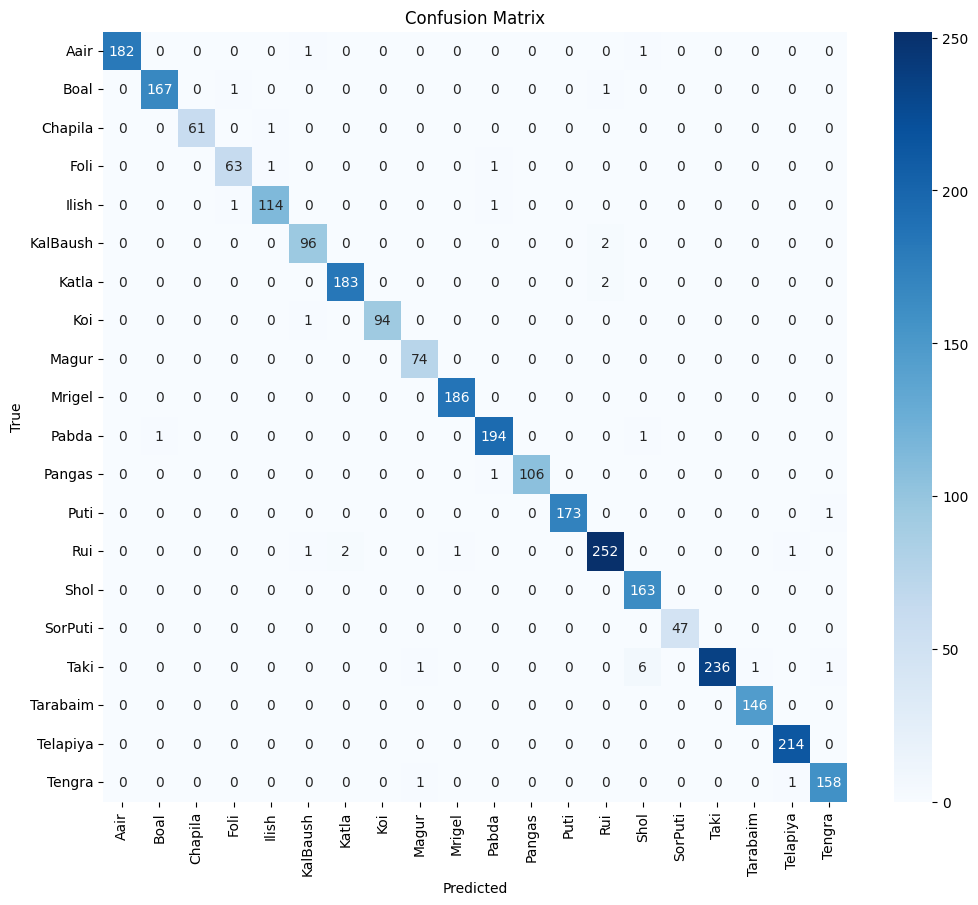

Macro Precision: 0.9882
Macro Recall: 0.9889
Macro F1-Score: 0.9885


In [28]:
# Cell 13: Predictions and Metrics (No change)
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Additional Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")

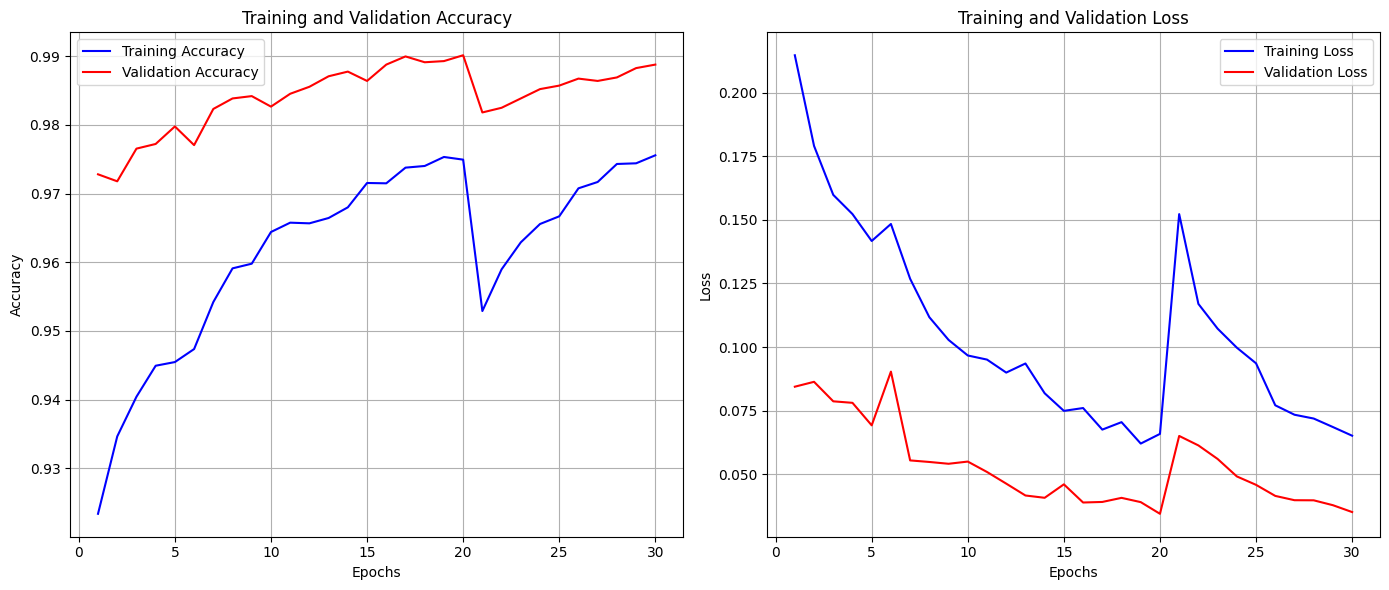

In [29]:
# তোমার history1 এবং history2 (Phase 1 + Phase 2) থেকে
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('accuracy_loss_curves.png', dpi=300)
plt.show()

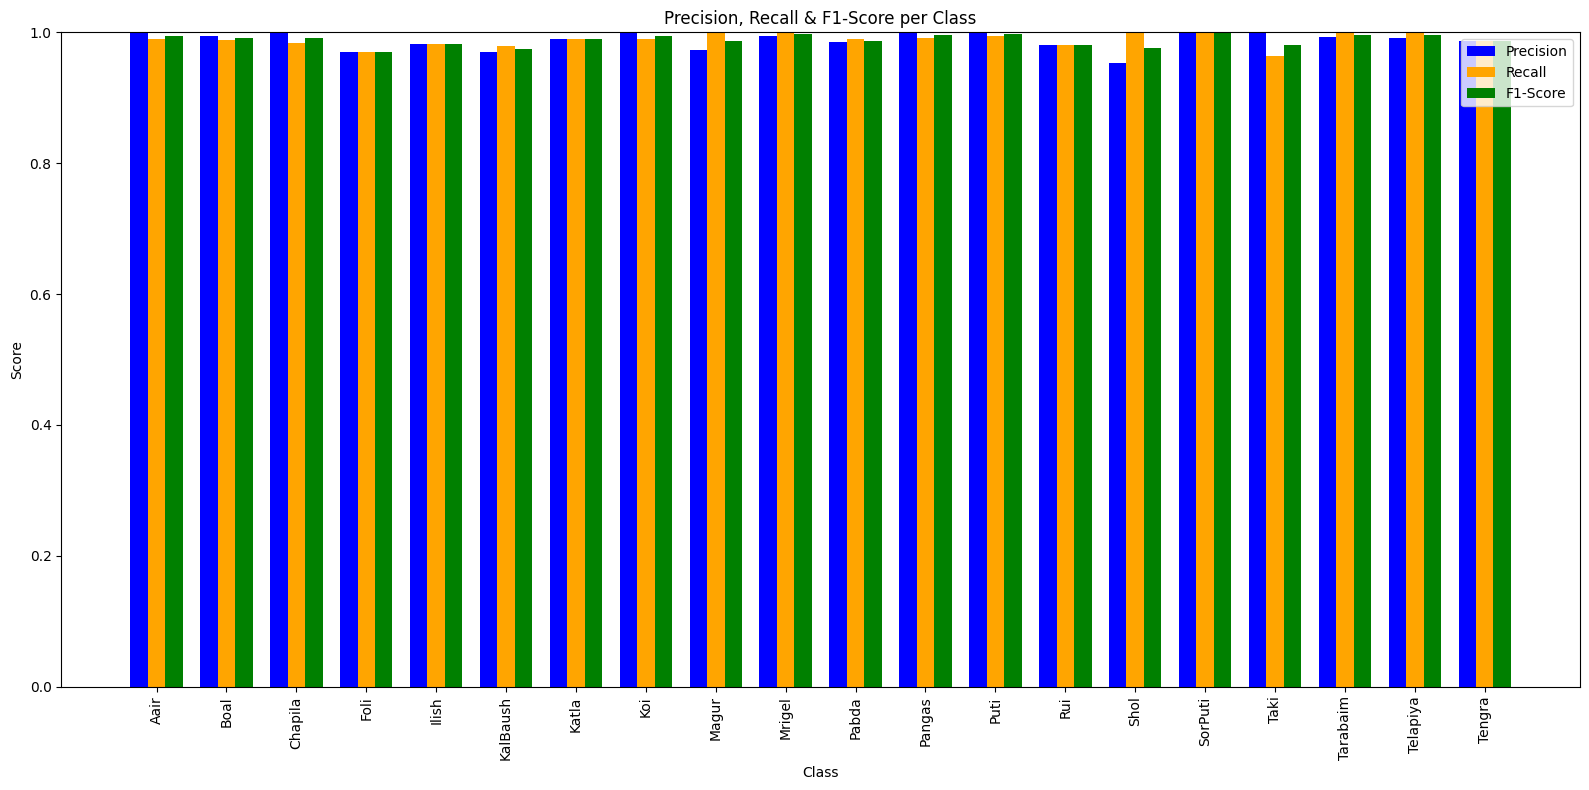

In [31]:
# Assuming class_names is the list of class labels

# Calculate precision, recall, and F1-score for each class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# Plotting the results
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.25
index = np.arange(len(class_names))

# Create subplots
plt.figure(figsize=(16, 8))

# Plot Precision, Recall, and F1 score for each class
plt.bar(index, precision_per_class, bar_width, label='Precision', color='blue')
plt.bar(index + bar_width, recall_per_class, bar_width, label='Recall', color='orange')
plt.bar(index + 2 * bar_width, f1_per_class, bar_width, label='F1-Score', color='green')

# Add labels, title and legend
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall & F1-Score per Class')
plt.xticks(index + bar_width, class_names, rotation=90)  # Class names on x-axis
plt.ylim(0, 1)  # Score range between 0 and 1

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
